We need to add 

(1) EM updates of the parameters of the prior on beta (spike + mixture of Gaussinans) ~ Theta, Theta_T; <br>
(2) Parameters of p y | z ~  gamma_{epsilon, t}. These are the parameters of the Weibull / Gumbell distributions for instance

In [1]:
from scipy.stats import norm
import numpy as np
import sympy
import scipy
import torch
from numpy import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm

In [2]:
# vampW code
# definition of Euler-Mascheroni constant
emc = float( sympy.S.EulerGamma.n(10) )

class prior:
    la = 0.5
    # Variances of the Gaussians in the mixture
    sigmas = [1]
    # Weights of the Gaussians in the mixture
    omegas = [1]
    def __init__(self, la, sigmas, omegas):
        self.la = la
        self.sigmas = sigmas
        self.omegas = omegas
    
def den_beta(r,gam1,prior): # checked!
    """
    This function returns the conditional expectation of the coefficients beta given the noisy estimate r
    The expectation is of the posterior distribution with the form of Spike and Slab mixture of Gaussians
    """
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))

    # How is this derived???
    # Is the sigma coming from the prior???
    # Note that gam1 * r / (gam1 + 1/sigma) = r / (1+1/(sigma*gam1)) = sigma * r / (sigma + 1/gam1)
    # This is equivalent to the formulation in the paper
    ratio = gam1 * r / (gam1 + 1/prior.sigmas[0]) * B / (A + B)
    return ratio



def der_den_beta(r,gam1,prior): # checked!
    # Derivative of the Gaussians with respect to r
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (prior.sigmas[0] + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/prior.sigmas[0]))
    print("alpha1 part I = ", gam1 / (gam1 + 1/prior.sigmas[0]) * B[1] / (A[1] + B[1]))
    print("alpha2 part II = ", BoverAplusBder[1] * r[1] * gam1 / (gam1 + 1.0/prior.sigmas[0]) )
    ratio = gam1 / (gam1 + 1/prior.sigmas[0]) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/prior.sigmas[0])
    return ratio

def den_z_non_lin_eq(z, tau1, p1, y, alpha, mu): # checked!
    # This is the negative of what is in the Overleaf. Still, this needs to be = 0 so *=-1 doesn't change the outcome
    res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return res
    
def den_z(p1, tau1, y, alpha, mu): # checked!
    """
    Performs component-wise optimization of the parameters z_i
    We assume independence of parameters of z_i 
    """
    n,_ = p1.shape
    out = np.zeros((n,1))
    for i in range(0, n):
        out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )
    return out

def der_den_z(p1, tau1, y, alpha, mu): # checked!
    # This is the second derivative of the expression g(z) to be maximized with the MAP estimation
    z = den_z(p1, tau1, y, alpha, mu)
    nom = tau1
    den = tau1 + alpha * alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return nom / den

In [3]:
# Simulate the input X
def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    #X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

# Simulate the coefficients beta
def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

def mathematica_evd(n, loc, scale):
    wi = np.random.gumbel(loc=loc, scale=scale, size=[n, 1])
    return wi

# Simulate the outcomes Y
def sim_pheno(X, beta, mu, h2):
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    varwi = np.pi * np.pi / 6
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    
    wi = -mathematica_evd(n=n, loc=-0, scale=1.0)
    # wi = -np.random.gumbel(loc=0, scale=1.0, size=[n, 1])

    y = np.exp(mu + g + c * (wi + emc) )
    # An equivalent formulation would be: 
    # y = np.exp(-mathematica_evd(n=n, loc = -(mu+g+c*emc), scale=c))
    alpha = 1.0 / c
    return y, alpha

def sim_model(n,m,p,la,sigma,h2):
    X = sim_geno(n,m,p)
    beta = sim_beta(m, la, sigma)
    mu = np.zeros((n,1))
    y, alpha = sim_pheno(X, beta, mu, h2)
    return X,beta,y,alpha

In [4]:
n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
h2=0.9
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)

In [5]:
def neg_log_likelihood_evd(X, beta, y, alpha, mu):
    log_eta = mu + X@beta + emc/alpha
    log_y = np.log(y)
    c = alpha*(log_y - log_eta)
    n, _ = y.shape
    return np.sum(np.exp(-np.exp(c) + c))*alpha
    # log_lik = np.sum(-np.exp(c) + c + np.log(alpha))
    return -log_lik 

In [6]:
def log_likelihood(X, beta, y, mu, alpha):
    K = torch.tensor(emc)
    X=torch.tensor(X)
    beta=torch.tensor(beta)
    y=torch.tensor(y) 
    mu=torch.tensor(mu)
    alpha=torch.tensor(alpha)
    z = X@beta
    c = torch.log(y) - mu - z - K / alpha
    return torch.sum(torch.log(alpha) + alpha * (torch.log(y) - mu - z - K / alpha) - torch.exp(alpha * (torch.log(y) - mu - z - K / alpha))).item()
log_likelihood(X, beta, y, 0, alpha)

489.68646089128765

In [7]:
def log_likelihood(X, beta, y, mu, alpha):
    K = torch.tensor(emc)
    X=torch.tensor(X)
    beta=torch.tensor(beta)
    y=torch.tensor(y) 
    mu=torch.tensor(mu)
    alpha=torch.tensor(alpha)
    z = X@beta
    c = alpha*(torch.log(y) - mu - z - K / alpha)
    return torch.sum(torch.log(alpha) + c - torch.exp(c)).item()
log_likelihood(X, beta, y, 0, alpha)

489.68646089128765

In [8]:
alpha

8.645629931925471

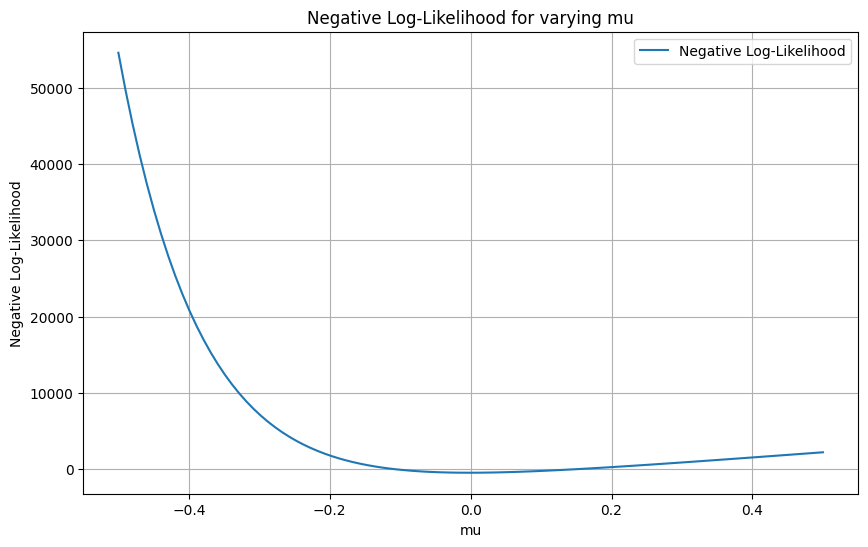

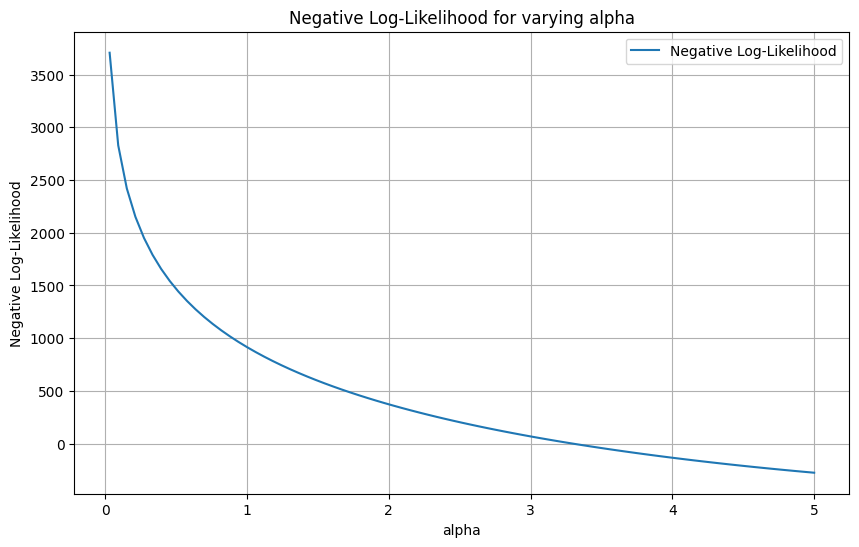

In [9]:
# Plot for varying mu
mus = np.linspace(-0.5, 0.5, 100)
neg_log_likelihoods_mu = [-log_likelihood(X, beta, y, mu, alpha) for mu in mus]

plt.figure(figsize=(10, 6))
plt.plot(mus, neg_log_likelihoods_mu, label='Negative Log-Likelihood')
plt.xlabel('mu')
plt.ylabel('Negative Log-Likelihood')
plt.title('Negative Log-Likelihood for varying mu')
plt.legend()
plt.grid(True)
plt.show()

# Plot for varying alpha
alphas = np.linspace(-1, 5, 100)
neg_log_likelihoods_alpha = [-log_likelihood(X, beta, y, 0, alpha) for alpha in alphas]

plt.figure(figsize=(10, 6))
plt.plot(alphas, neg_log_likelihoods_alpha, label='Negative Log-Likelihood')
plt.xlabel('alpha')
plt.ylabel('Negative Log-Likelihood')
plt.title('Negative Log-Likelihood for varying alpha')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
mu = 0
log_eta = mu + X@beta + emc/alpha
log_y = np.log(y)
c = alpha*(log_y - log_eta)
n, _ = y.shape

In [11]:
-np.sum(-np.exp(c) + c + n*np.log(alpha))

-1379278.5924585604

In [12]:
-np.sum(np.exp(-np.exp(c) + c)-n*np.log(alpha))

1380310.2856492042

In [13]:
# return -np.sum(np.exp(-np.exp(c) + c))+n*np.log(alpha)
# log_lik = np.sum(-np.exp(c) + c + np.log(alpha))
# return -log_lik 

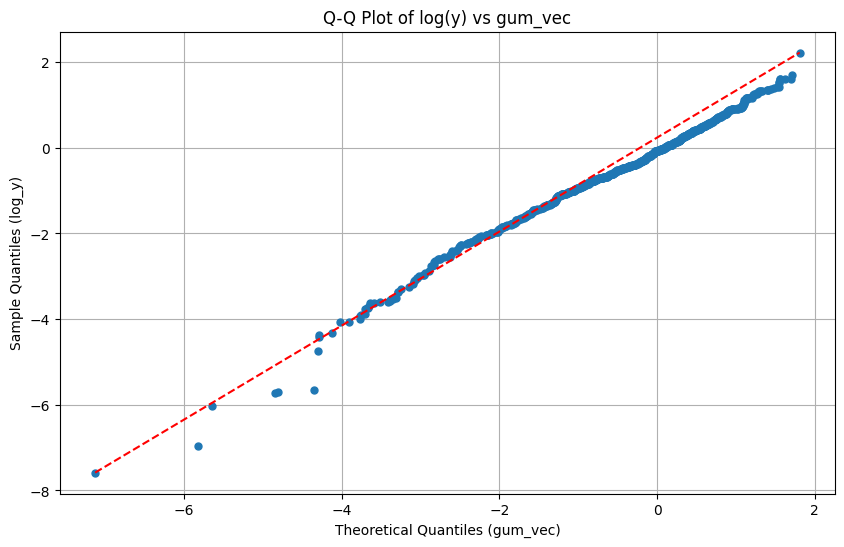

In [14]:
# Sort the vectors
log_y = alpha * (np.log(y) - X@beta - np.zeros((n,1)) - emc / alpha)
gum_vec = -mathematica_evd(n=n, loc=-0, scale=1.0)
sorted_gum_vec = np.sort(gum_vec.flatten())
sorted_log_y = np.sort(log_y.flatten())

# Create Q-Q plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_gum_vec, sorted_log_y, 'o', markersize=5)
plt.plot([min(sorted_gum_vec), max(sorted_gum_vec)], [min(sorted_log_y), max(sorted_log_y)], 'r--')

# Add title and labels
plt.title('Q-Q Plot of log(y) vs gum_vec')
plt.xlabel('Theoretical Quantiles (gum_vec)')
plt.ylabel('Sample Quantiles (log_y)')

# Show plot
plt.grid(True)
plt.show()

In [15]:
### WEIBULL MODEL ###
def update_Weibull_alpha_eq(alpha, y, mu, z_hat, xi):
    n,_ = y.shape
    out = np.zeros(n)
    res = np.log(y) - mu - z_hat
    out = np.sum(res) - np.exp(-emc) * np.sum( np.exp(alpha * res + (alpha**2)/2/xi) * (res + alpha/xi) )
    return out

def update_Weibull_alpha(y, mu, z_hat, alpha_old, xi):
    # y.shape = [n,1]
    # z_hat.shape = [n,1]
    alpha_new = scipy.optimize.fsolve(update_Weibull_alpha_eq, x0 = alpha_old, args=(y, mu, z_hat, xi))
    if isinstance(alpha_new, np.ndarray) or isinstance(alpha_new, list): alpha_new = float(alpha_new[0])
    return alpha_new

def update_Weibull_mu(y, z_hat, alpha, xi):
    # y.shape = [n,1]
    # z_hat.shape = [n,1]
    n,_ = y.shape
    mu_new = - np.log(n) / alpha - emc/alpha + alpha / 2 / xi + 1 / alpha * np.log(np.sum(np.exp(alpha*(np.log(y) - z_hat))))
    if isinstance(mu_new, np.ndarray) or isinstance(mu_new, list): mu_new = float(mu_new[0])
    return mu_new

In [16]:
# Define the Weibull likelihood function in PyTorch
def weibull_likelihood_og(z_hat, Y, a, mu, xi, K):
    term1 = torch.exp(-a * mu - a * z_hat - K)
    term2 = Y ** a * torch.exp(a ** 2 / (2 * xi))
    term3 = a * torch.exp(a * z_hat + K) * mu
    term4 = (torch.exp(K) * a * z_hat - torch.exp(K) * torch.log(Y) * a + K * torch.exp(K)) * torch.exp(a * z_hat)
    term5 = torch.exp(a * mu)

    result = -term1 * (term2 + (term3 + term4) * term5)
    return torch.sum(result)

def update_params(optimizer, z_hat, Y, a, mu, xi, K):
    # Convert data to PyTorch tensors
    z_hat = torch.tensor(z_hat, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    xi = torch.tensor(xi, dtype=torch.float32)
    K = torch.tensor(K, dtype=torch.float32)

    # Optimization step
    for step in range(100):  # Number of optimization steps
        optimizer.zero_grad()
        loss = -weibull_likelihood(z_hat, Y, a, mu, xi, K)  # Negate to maximize
        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item()}, a: {a.item()}, mu: {mu.item()}")

    print(f"Final a: {a.item()}, Final mu: {mu.item()}")
    return a.item(), mu.item()

In [17]:
import matplotlib.pyplot as plt

def gvamp(X, gam1, r1, tau1, p1, prior, y, alpha, mu, maxiter, beta_true):
    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    actual_xis = []
    predicted_xis = []
    dl_dmus = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, prior)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################
        alpha1 = np.mean( der_den_beta(r1, gam1, prior) )
        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, alpha, mu)
        # print("\n\n\n")
        # print(f"Alpha new: {alpha_new}; type: {type(alpha_new)}")
        ############################################################
        # Cosine similarity
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        ############################################################

        beta_1 = np.mean( der_den_z(p1, tau1, y, alpha, mu) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)
        predicted_xi = tau1 / beta_1
        predicted_xis.append(predicted_xi)
        actual_xi = 1 / np.var(X@beta-z1_hat)
        actual_xis.append(actual_xi)
        # alpha = torch.tensor(float(alpha), requires_grad=True)
        # mu = torch.tensor(float(mu), requires_grad=True)

        # optimizer = optim.Adam([alpha, mu], lr=0.01)
        
        # alpha, mu = update_params(optimizer, z1_hat, y, alpha, mu, 1e-4, K=emc)
        
        # alphas.append(alpha)
        # mus.append(mu)
        # alpha_new = update_Weibull_alpha(y, mu, z1_hat, alpha, 1/actual_xi)
        # if(not np.isnan(alpha_new)): 
        #     print(f"Changing alpha from {alpha} to {alpha_new}")
        #     alpha = alpha_new
        # alphas.append(alpha)




        
        def dl_dmu(y, z_hat, alpha, xi, mu):
            # Both return 0 successfully
            # result = mu -  update_Weibull_mu(y, z_hat, alpha, xi)
            # result = mu - (- np.log(n) / alpha - emc/alpha + alpha / 2 / xi + 1 / alpha * np.log(np.sum(np.exp(alpha*(np.log(y) - z_hat)))))
            # return result

            # mu = - np.log(n) / alpha - emc/alpha + alpha / 2 / xi + 1 / alpha * np.log(np.sum(np.exp(alpha*(np.log(y) - z_hat))))

            term1 = -emc
            term2 = (alpha ** 2) / (2 * xi)
            term3 = -alpha * mu
            sum_exp = np.sum(np.exp(alpha * (np.log(y) - z_hat)))
            
            result = np.exp(term1 + term2 + term3) * sum_exp - len(y)
            return result



        # mu_new = update_Weibull_mu(y, z1_hat, alpha, actual_xi)
        # if(not np.isnan(mu_new)):  
        #     print(f"Changing mu from {mu} to {mu_new}")
        #     mu = mu_new
        # mu_new = mu
        # mus.append(mu)

        dl_dmus.append(dl_dmu(y, z1_hat, alpha, actual_xi, 0))
        # if isinstance(mu_new, np.ndarray) or isinstance(mu_new, list): mu_new = float(mu_new[0])
        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")
            


    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, actual_xis, predicted_xis, dl_dmus

n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)

# These are the initial estimates
# gam1 = 1.0 / (sigma)
gam1 = 1e-2

print("gam1 = ", gam1)
pr = prior(la = la, sigmas = [sigma], omegas = [omega])
# mu = 0
mu = 0
# alpha = 1e-1
print("Var(y) = ", np.var(y))
# tau1 = 1.0 / np.var(X @ beta)
tau1 = 1e-1
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])

maxiter = 10

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, p, dl_dmus = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha, mu, maxiter, beta)

gam1 =  0.01
Var(y) =  0.5610457412684644
tau1 =  0.1
alpha =  2.9797767722763298
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.4349186836136654
gam2 =  2.5225561565998147


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_18917/980534439.py:60: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.6195492313744646
l2 error for z1_hat =  0.8806884329246404
v1 =  0.041226593983702015
true tau2 =  6.521937582986245
tau2 = 2.325618765390435
->LMMSE
corr(x2_hat, beta_true) =  [[0.52999996]]
l2 error for x2_hat =  0.8801497861862113
alpha2 =  0.7500580645808695
true gam1 =  2.1391746959462656
gam1 =  0.8405916791739562
corr(z2_hat, beta_true) =  [[0.74373502]]
l2 error for z2_hat =  0.7496524247558247
true tau1 =  7.275023096234441
tau1 =  6.979017375361931


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [0.00378365]
corr(x1_hat, beta_true) =  0.5462310402524332
l2 error for x1_hat =  0.8939449580955834
B / (A+B) =  [0.33350582]
gam1 / (gam1 + 1/sigma) =  0.45669644641184487
alpha1 part I =  [0.15231092]
alpha2 part II =  [0.00368244]
alpha1 =  0.1854871469252834
true gam2 =  2.4986267262699333
gam2 =  3.6912138561850907
corr(z1_hat, X*beta_true) =  0.7546666006241117
l2 error for z1_hat =  0.6575169357011288
v1 =  0.5035340935266743
true tau2 =  

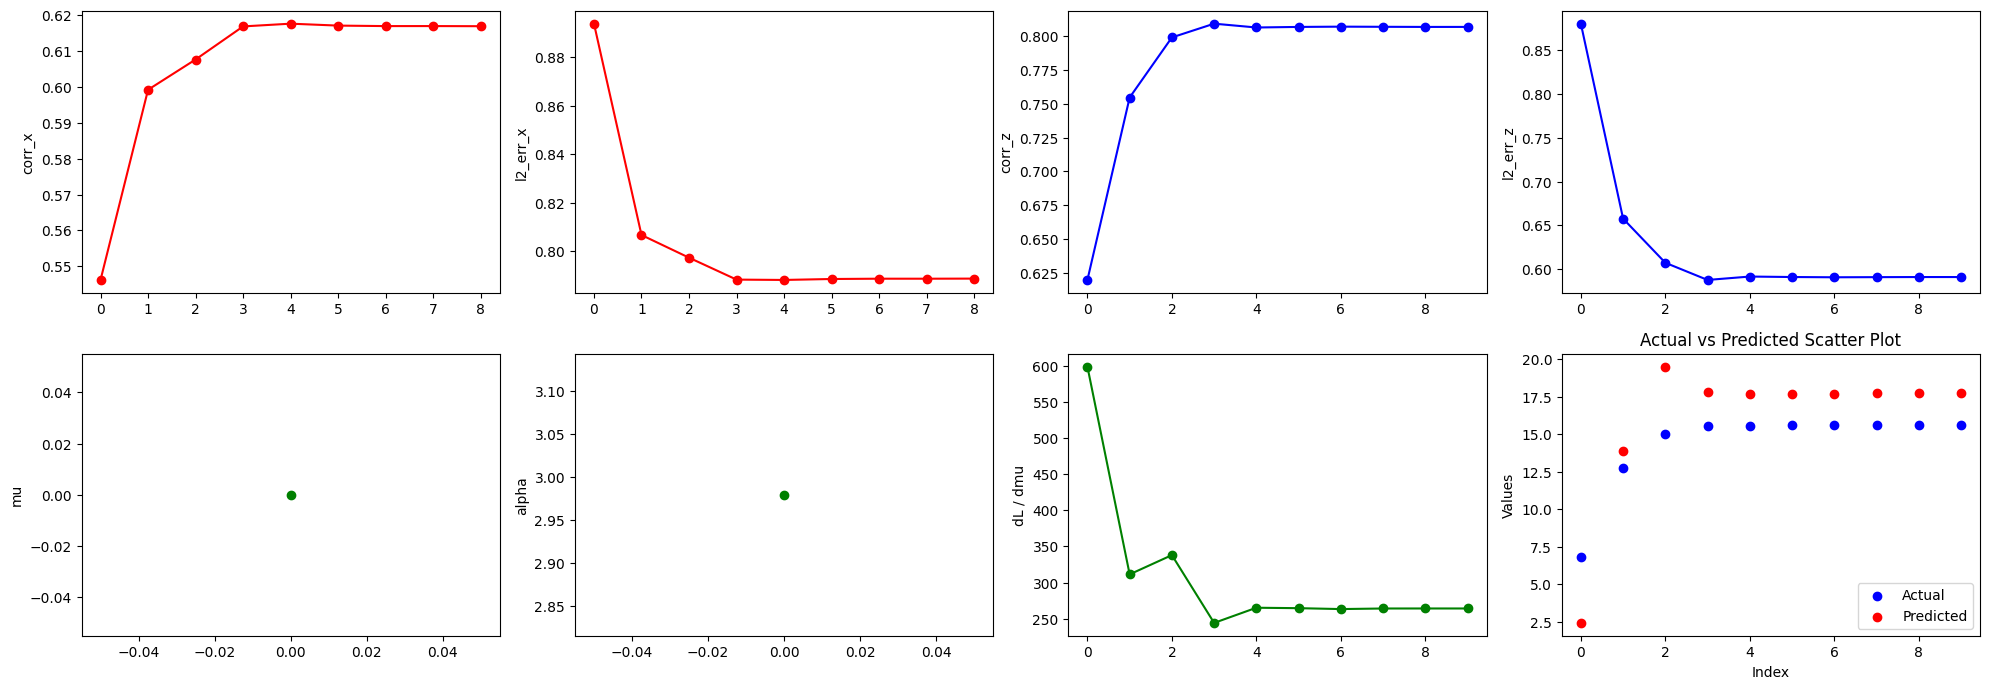

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# Plotting corr_x
plt.subplot(3, 4, 1)
plt.ylabel('corr_x')
plt.plot(range(len(corrs_x)), corrs_x, 'ro-')

# Plotting l2_err_x
plt.subplot(3, 4, 2)
plt.ylabel('l2_err_x')
plt.plot(range(len(l2_errs_x)), l2_errs_x, 'ro-')

# Plotting corr_z
plt.subplot(3, 4, 3)
plt.ylabel('corr_z')
plt.plot(range(len(corrs_z)), corrs_z, 'bo-')

# Plotting l2_err_z
plt.subplot(3, 4, 4)
plt.ylabel('l2_err_z')
plt.plot(range(len(l2_errs_z)), l2_errs_z, 'bo-')

# Plotting mu evolution
plt.subplot(3, 4, 5)
plt.ylabel('mu')
plt.plot(range(len(mus)), mus, 'go-')

# Plotting alpha evolution
plt.subplot(3, 4, 6)
plt.ylabel('alpha')
plt.plot(range(len(alphas)), alphas, 'go-')

# Plotting dL / dmu
plt.subplot(3, 4, 7)
plt.ylabel('dL / dmu')
plt.plot(range(len(dl_dmus)), dl_dmus, 'go-')

# Plotting Actual vs Predicted Scatter Plot in the last cell
plt.subplot(3, 4, 8)
indices = range(len(a))
plt.scatter(indices, a, color='blue', label='Actual')
plt.scatter(indices, p, color='red', label='Predicted')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Scatter Plot')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
# Simulate the input X
def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    # X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

# Simulate the coefficients beta
def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

# Simulate the outcomes Y
def sim_pheno(X, beta, mu, h2):
    # beta is mx1 vector 
    # mu is nx1 vector 
    # h2 is the heritability parameter
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    varwi = np.pi * np.pi / 6

    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    # c = np.sqrt((1-h2) * sigmaG / varwi)
    # c = np.sqrt((1-h2) * sigmaG / varwi)

    # Why does the - arise here?
    wi = - random.gumbel(loc=0.0, scale=1.0, size=[n,1])
    # wi = random.gumbel(loc=0.0, scale=1.0, size=[n,1])
    # c = 1 / a
    y = np.exp( mu + g + c * (wi + emc) )
    alpha = 1.0 / c
    return y, alpha

def sim_model(n,m,p,la,sigma,h2):
    X = sim_geno(n,m,p)
    beta = sim_beta(m, la, sigma)
    mu = np.zeros((n,1))
    y, alpha = sim_pheno(X, beta, mu, h2)
    return X,beta,y,alpha

In [20]:
n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
h2=0.5
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)

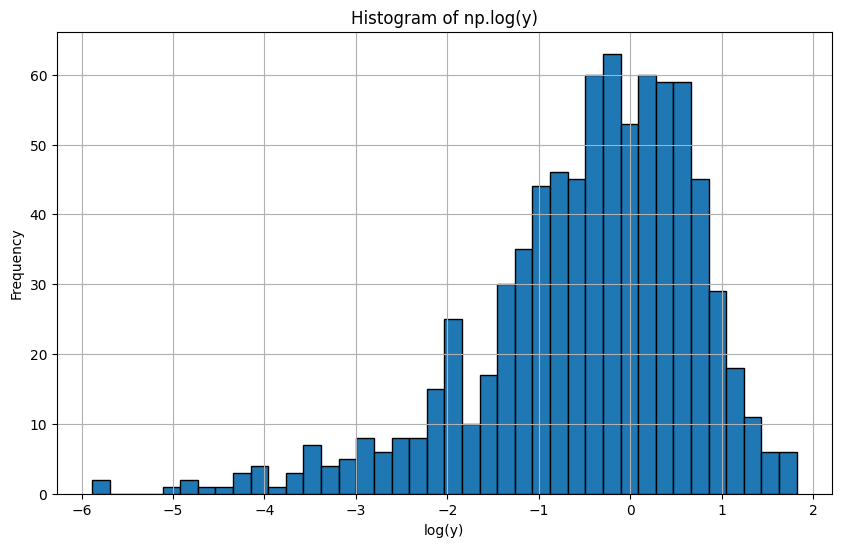

In [21]:
log_y = alpha * (np.log(y) - X@beta - np.zeros((n,1))) - emc
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(log_y, bins=40, edgecolor='black')
plt.title('Histogram of np.log(y)')
plt.xlabel('log(y)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

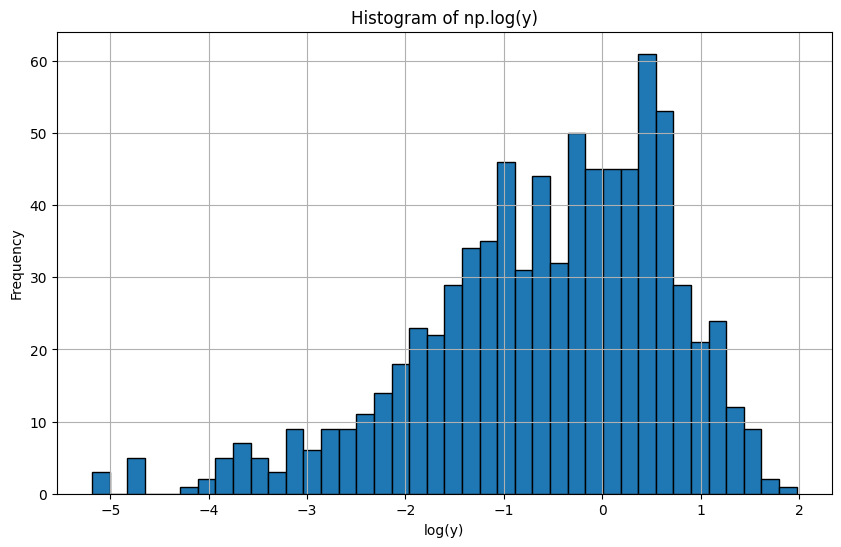

In [22]:
# Plot the histogram
gum_vec = -random.gumbel(loc=0.0, scale=1.0, size=[n,1])
plt.figure(figsize=(10, 6))
plt.hist(gum_vec.flatten(), bins=40, edgecolor='black')
plt.title('Histogram of np.log(y)')
plt.xlabel('log(y)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

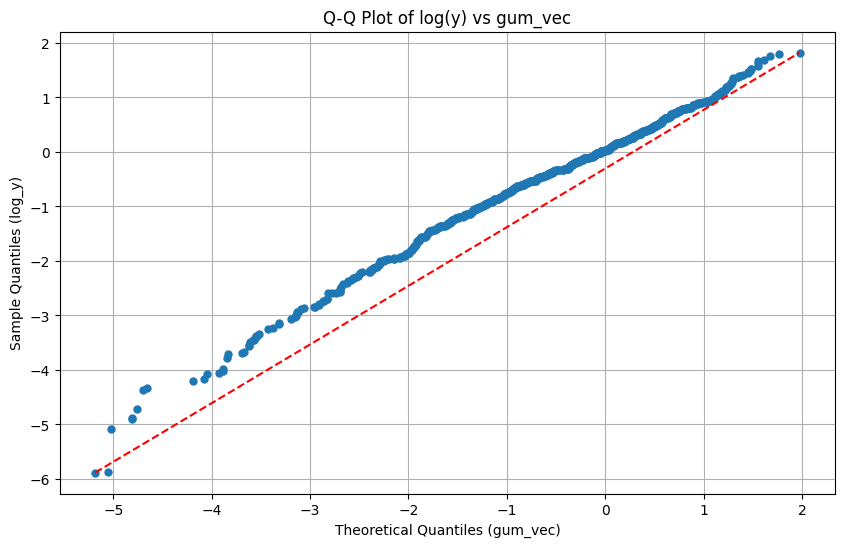

In [23]:
# Sort the vectors
sorted_gum_vec = np.sort(gum_vec.flatten())
sorted_log_y = np.sort(log_y.flatten())

# Create Q-Q plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_gum_vec, sorted_log_y, 'o', markersize=5)
plt.plot([min(sorted_gum_vec), max(sorted_gum_vec)], [min(sorted_log_y), max(sorted_log_y)], 'r--')

# Add title and labels
plt.title('Q-Q Plot of log(y) vs gum_vec')
plt.xlabel('Theoretical Quantiles (gum_vec)')
plt.ylabel('Sample Quantiles (log_y)')

# Show plot
plt.grid(True)
plt.show()

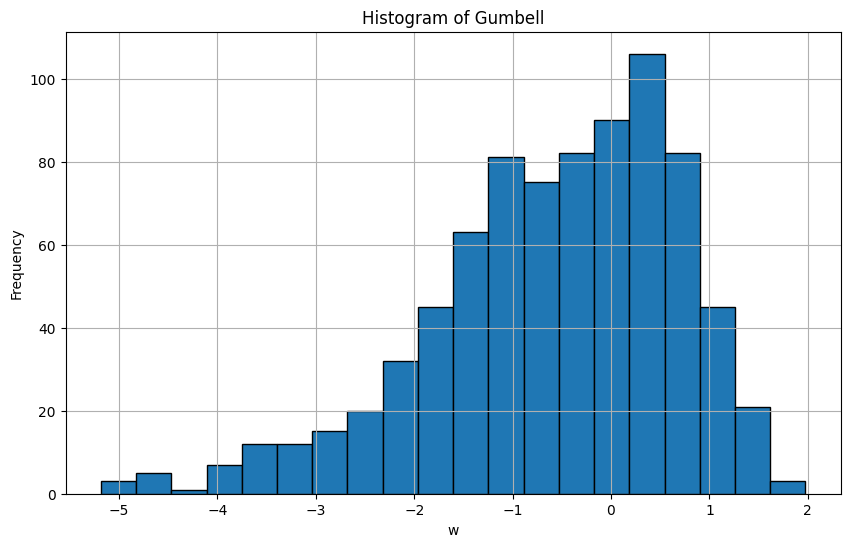

In [24]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(gum_vec, bins=20, edgecolor='black')
plt.title('Histogram of Gumbell')
plt.xlabel('w')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [38]:
alpha

3.2313809782997356

In [39]:
def log_likelihood(X, beta, y, mu, alpha):
    K = torch.tensor(emc)
    X=torch.tensor(X)
    beta=torch.tensor(beta)
    y=torch.tensor(y) 
    mu=torch.tensor(mu)
    alpha=torch.tensor(alpha)
    z = X@beta
    return torch.sum(torch.log(alpha) + alpha * (torch.log(y) - mu - z - K / alpha) - torch.exp(alpha * (torch.log(y) - mu - z - K / alpha))).item()
log_likelihood(X, beta, y, 0, alpha)

-267.87789644492733

In [40]:
def log_likelihood(X, beta, y, mu, alpha):
    K = torch.tensor(emc)
    X=torch.tensor(X)
    beta=torch.tensor(beta)
    y=torch.tensor(y) 
    mu=torch.tensor(mu)
    alpha=torch.tensor(alpha)
    z = X@beta
    c = alpha*(torch.log(y) - mu - z - K / alpha)
    return torch.sum(torch.log(alpha) + c - torch.exp(c)).item()
log_likelihood(X, beta, y, 0, alpha)

-267.87789644492733

In [28]:
def integrand(z_i, y_i, hat_z_i, xi_k, alpha, mu, K):
    # Calculate the Gaussian probability density function
    gaussian_pdf = norm.pdf(z_i, loc=hat_z_i, scale=np.sqrt(1 / xi_k))
    
    # Calculate the log p(y_i | z_i, alpha, mu)
    log_p = alpha * (np.log(y_i) - mu - z_i) - K - np.exp(alpha * (np.log(y_i) - mu - z_i) - K) + np.log(alpha)
    
    # Return the product of the Gaussian PDF and log p
    return gaussian_pdf * log_p

def compute_integral_sum(y, hat_z, xi_k, alpha, mu, K):
    integral_sum = 0.0
    N = len(y)
    m_error = 0
    
    for i in range(N):
        y_i = y[i]
        hat_z_i = hat_z[i]
        
        # Perform the numerical integration for each term
        integral_value, error = quad(integrand, -100, 100, args=(y_i, hat_z_i, xi_k, alpha, mu, K))
        m_error = max(m_error, error)
        
        # Sum up the integrals
        integral_sum += integral_value
    
    return integral_sum, m_error

In [29]:
def likelihood_with_belief(X, beta, y, mu, alpha):
    hat_z = X@beta
    xi = 15
    return compute_integral_sum(y, hat_z, xi, alpha, mu, emc)

This code finds the correct alpha and mu

The mu_value that minimizes the negative log likelihood is: 0.010204081632653073
Original value: 0


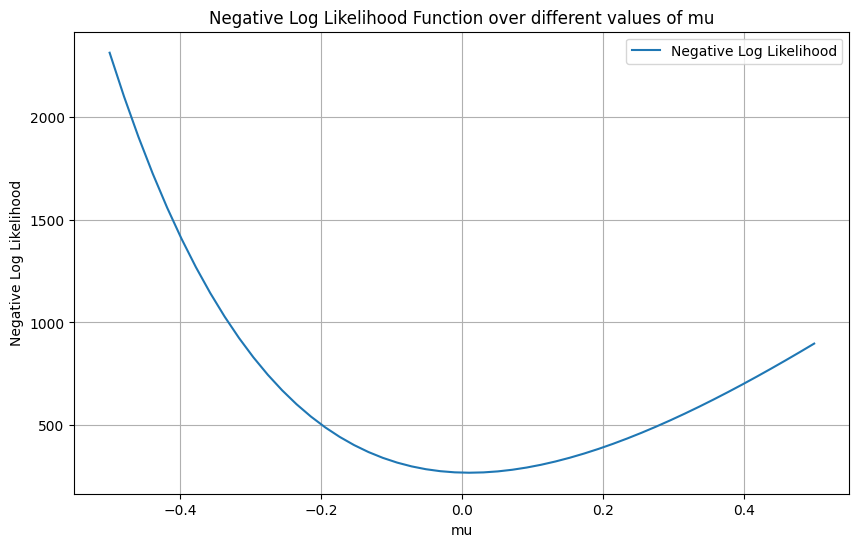

In [41]:
# Generate 1000 values of mu from -100 to 100
# log_likelihood(X, beta, y, mu, alpha):
mu_values = np.linspace(-0.5, 0.5, 50)
neg_log_likelihood_values  = [-log_likelihood(X, beta, y, mu, alpha) for mu in mu_values]

# Find the index of the minimum neg_log_likelihood value
min_index = np.argmin(neg_log_likelihood_values)

# Find the corresponding a_value
mu_min = mu_values[min_index]

print(f"The mu_value that minimizes the negative log likelihood is: {mu_min}")
print(f"Original value: {0}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mu_values, neg_log_likelihood_values, label='Negative Log Likelihood')
plt.xlabel('mu')
plt.ylabel('Negative Log Likelihood')
plt.title('Negative Log Likelihood Function over different values of mu')
plt.legend()
plt.grid(True)
plt.show()

The a_value that minimizes the negative log likelihood is: 3.371717171717172
Original value: 3.2313809782997356


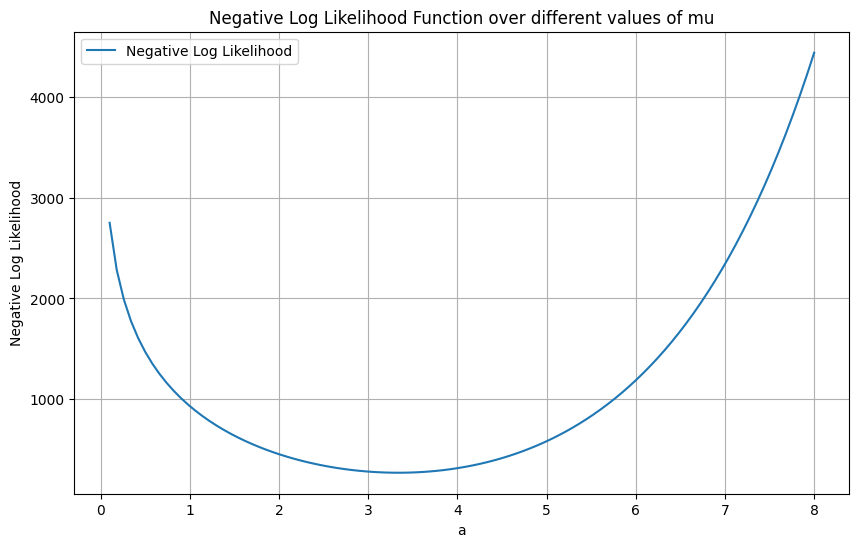

In [31]:
# Generate 1000 values of mu from -100 to 100
# log_likelihood(X, beta, y, mu, alpha):
a_values = np.linspace(0.1, 8, 100)
neg_log_likelihood_values  = [-log_likelihood(X, beta, y, 0, a) for a in a_values]

# Find the index of the minimum neg_log_likelihood value
a_index = np.argmin(neg_log_likelihood_values)

# Find the corresponding a_value
a_min = a_values[a_index]

print(f"The a_value that minimizes the negative log likelihood is: {a_min}")
print(f"Original value: {alpha}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(a_values, neg_log_likelihood_values, label='Negative Log Likelihood')
plt.xlabel('a')
plt.ylabel('Negative Log Likelihood')
plt.title('Negative Log Likelihood Function over different values of mu')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
np.argmin(neg_log_likelihood_values)

41

In [33]:
np.linspace(0.1, 8, 100)[36]

2.9727272727272727

In [34]:
neg_log_likelihood_values[36]

280.0040326403738

In [35]:
neg_log_likelihood_values

[2752.179052905002,
 2282.621651922462,
 1988.939087094102,
 1775.034063180675,
 1606.9896921620746,
 1468.8361634098246,
 1351.7677908835767,
 1250.410424053357,
 1161.242127018621,
 1081.8295600346157,
 1010.4215069748669,
 945.7161362746522,
 886.7198605121207,
 832.6576720077587,
 782.9139485405677,
 736.9920906296421,
 694.4862297328369,
 655.0609195414303,
 618.4362519894023,
 584.37674809195,
 552.6829312486867,
 523.184842732936,
 495.7369871655884,
 470.21434691367034,
 446.5092065799603,
 424.5285991814086,
 404.1922349617121,
 385.43080889312574,
 368.18460825624334,
 352.40236020436134,
 338.0402729178066,
 325.06123420036636,
 313.4341391141032,
 303.13332415816103,
 294.1380900472023,
 286.43229867827597,
 280.0040326403738,
 274.8453078018701,
 270.9518312432801,
 268.322798188025,
 266.96072269886156,
 266.87129781066426,
 268.06328150604224,
 270.5484055433153,
 274.34130464344014,
 279.4594639545163,
 285.92318305595603,
 293.7555550523225,
 302.9824595495449,
 313.63

In [36]:
# Generate 1000 values of mu from -100 to 100
# log_likelihood(X, beta, y, mu, alpha):
mu_values = np.linspace(-0.5, 0.5, 10)
vals_n_errors = [likelihood_with_belief(X, beta, y, mu, alpha) for mu in mu_values]

neg_log_likelihood_values = [-val for val, err in vals_n_errors]

# Find the index of the minimum neg_log_likelihood value
min_index = np.argmin(neg_log_likelihood_values)

# Find the corresponding a_value
mu_min = mu_values[min_index]

print(f"The mu_value that minimizes the negative log likelihood is: {mu_min}")
print(f"Original value: {mu}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mu_values, neg_log_likelihood_values, label='Negative Log Likelihood')
plt.xlabel('mu')
plt.ylabel('Negative Log Likelihood')
plt.title('Negative Log Likelihood Function over different values of mu')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
# Generate 1000 values of mu from -100 to 100
# log_likelihood(X, beta, y, mu, alpha):
mu_values = np.linspace(-0.5, 0.5, 10)
vals_n_errors = [likelihood_with_belief(X, beta, y, mu, alpha) for mu in mu_values]

neg_log_likelihood_values = [-val for val, err in vals_n_errors]

# Find the index of the minimum neg_log_likelihood value
min_index = np.argmin(neg_log_likelihood_values)

# Find the corresponding a_value
mu_min = mu_values[min_index]

print(f"The mu_value that minimizes the negative log likelihood is: {mu_min}")
print(f"Original value: {mu}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mu_values, neg_log_likelihood_values, label='Negative Log Likelihood')
plt.xlabel('mu')
plt.ylabel('Negative Log Likelihood')
plt.title('Negative Log Likelihood Function over different values of mu')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

The mu_value that minimizes the negative log likelihood is: -0.0005005005005004892
Original value: 0


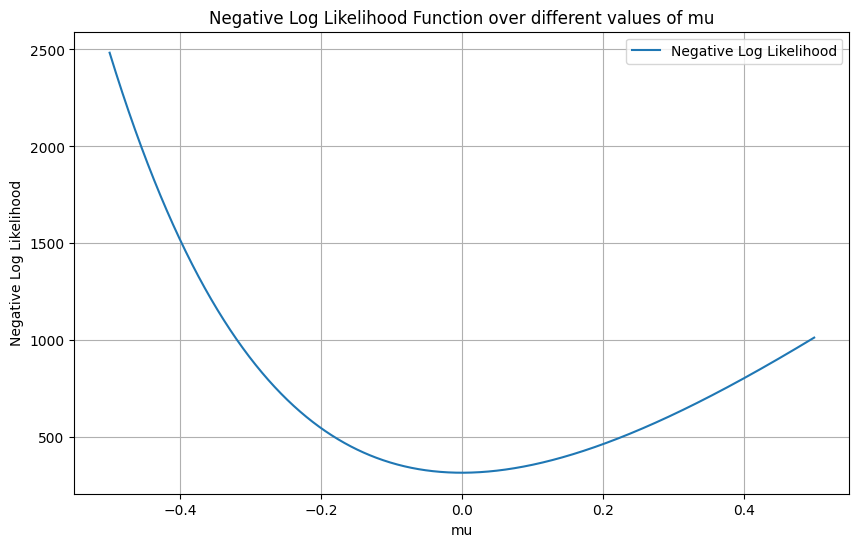

In [ ]:
# Generate 1000 values of mu from -100 to 100
mu_values = np.linspace(-0.5, 0.5, 10)
neg_log_likelihood_values = [-log_likelihood(X, beta, y, mu, alpha) for mu in mu_values]
# Find the index of the minimum neg_log_likelihood value
min_index = np.argmin(neg_log_likelihood_values)

# Find the corresponding a_value
mu_min = mu_values[min_index]

print(f"The mu_value that minimizes the negative log likelihood is: {mu_min}")
print(f"Original value: {mu}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mu_values, neg_log_likelihood_values, label='Negative Log Likelihood')
plt.xlabel('mu')
plt.ylabel('Negative Log Likelihood')
plt.title('Negative Log Likelihood Function over different values of mu')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def likelihood_with_belief(X, beta, y, mu, alpha):
    hat_z = X@beta
    xi = 15
    return compute_integral_sum(y, hat_z, xi, alpha, mu, emc)

The a_value that minimizes the negative log likelihood is: 0.45000000000000007
Original value: 5.6


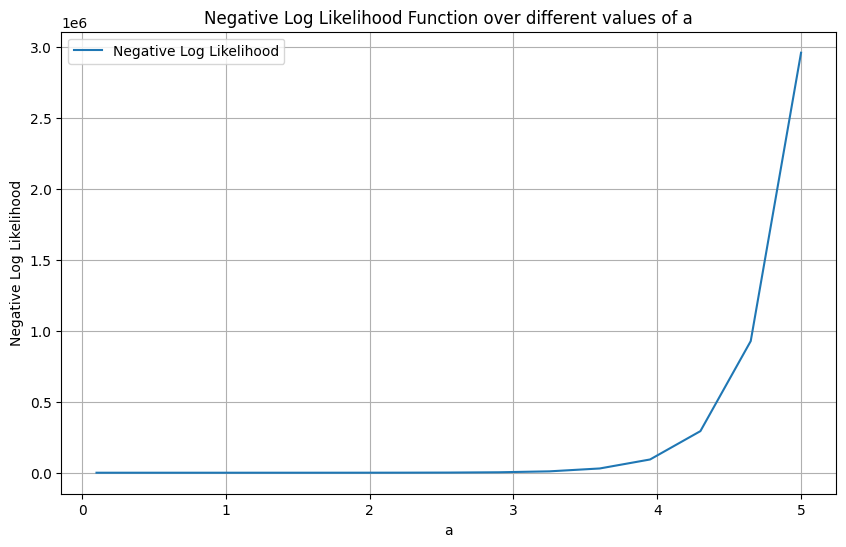

In [ ]:
# Generate 1000 values of mu from -100 to 100
a_values = np.linspace(0.1, 5, 15)
vals_n_errors = [likelihood_with_belief(X, beta, y, 0, a) for a in a_values]

neg_log_likelihood_values = [-val for val, err in vals_n_errors]

# Find the index of the minimum neg_log_likelihood value
min_index = np.argmin(neg_log_likelihood_values)

# Find the corresponding a_value
mu_min = a_values[min_index]

print(f"The a_value that minimizes the negative log likelihood is: {mu_min}")
print(f"Original value: {mu}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(a_values, neg_log_likelihood_values, label='Negative Log Likelihood')
plt.xlabel('a')
plt.ylabel('Negative Log Likelihood')
plt.title('Negative Log Likelihood Function over different values of a')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
vals_n_errors

[(-3.4518851342156003, 6.465627290867087e-09),
 (-1.9256855034157623, 2.866275978704284e-09),
 (-3.282157126004173, 2.1913674854374184e-10),
 (-10.598543309814673, 6.442914029091432e-09),
 (-35.05479686351143, 3.348509401673833e-08),
 (-110.51202995783572, 1.220162637710745e-07),
 (-339.52694949999864, 3.7904166115718086e-07),
 (-1034.9464972193357, 1.4957613203181279e-05),
 (-3158.6664591256053, 2.5076280625839368e-06),
 (-9691.943608504163, 5.1611566150551805e-06),
 (-29949.17535682176, 8.32827699069616e-06),
 (-93266.07022058906, 1.2500952150218403e-05),
 (-292780.44619442977, 4.281197806232928e-05),
 (-926580.0765096657, 0.00029481254384755573),
 (-2956391.9208268914, 0.001699461737028729)]

The a_value that minimizes the negative log likelihood is: 0.7909090909090909
Original value: 2.9169205004382555


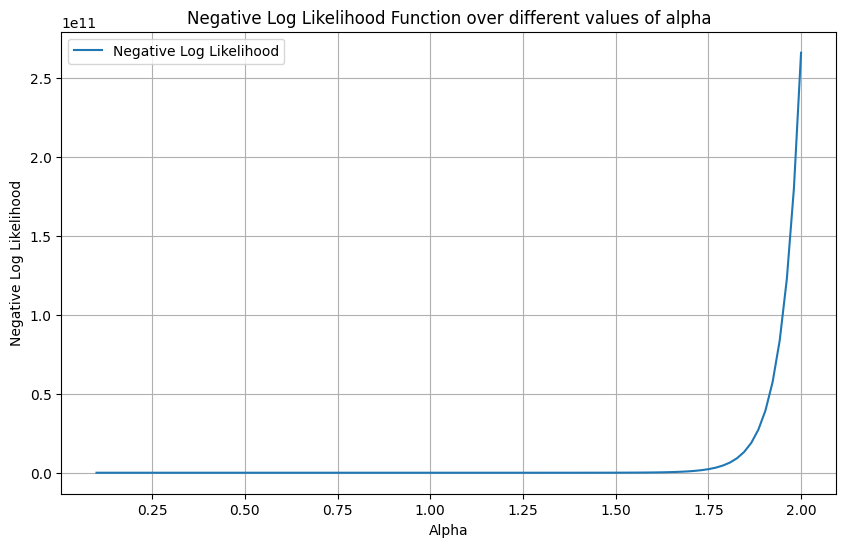

In [ ]:
# Generate 1000 values of mu from -100 to 100
a_values = np.linspace(0.1, 2, 100)
vals_n_errors = [-weibull_likelihood_corrected(torch.tensor(X@beta), torch.tensor(y), torch.tensor(a), torch.tensor(0), torch.tensor(0.1), torch.tensor(emc)) for a in a_values]
# neg_log_likelihood_values = [-val for val, err in vals_n_errors]

# Find the index of the minimum neg_log_likelihood value
min_index = np.argmin(neg_log_likelihood_values)

# Find the corresponding a_value
a_min = a_values[min_index]

print(f"The a_value that minimizes the negative log likelihood is: {a_min}")
print(f"Original value: {alpha}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(a_values, vals_n_errors, label='Negative Log Likelihood')
plt.xlabel('Alpha')
plt.ylabel('Negative Log Likelihood')
plt.title('Negative Log Likelihood Function over different values of alpha')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def plot_likelihood(interval_s, interval_e, num_points, lik_func, var_type, lik_type, alpha, mu=0, xi=15):
    # Generate 1000 values of mu from -100 to 100
    values = np.linspace(interval_s, interval_e, num_points)
    
    if var_type == "alpha":
            og_val = alpha
            if lik_type == "weibull_belief":
                neg_log_likelihood_values = [-lik_func(
                      torch.tensor(X@beta), 
                      torch.tensor(y), 
                      torch.tensor(a),
                      torch.tensor(mu),
                      torch.tensor(xi),
                      torch.tensor(emc),
                ) for a in values]
            else:
                neg_log_likelihood_values = [-lik_func(
                     X,
                     beta, 
                     y, 
                     mu, 
                     a) 
                for a in values]
            
    elif var_type == "mu":
            og_val = mu
            if lik_type == "weibull_belief":
                neg_log_likelihood_values = [-lik_func(
                      torch.tensor(X@beta), 
                      torch.tensor(y), 
                      torch.tensor(alpha),
                      torch.tensor(m),
                      torch.tensor(xi),
                      torch.tensor(emc),
                ) for m in values]
            else:
                neg_log_likelihood_values = [-lik_func(
                     X,
                     beta, 
                     y, 
                     m, 
                     alpha) 
                for m in values]
            
    min_index = np.argmin(neg_log_likelihood_values)
    min_val = values[min_index]

    print(f"The {var_type} value that minimizes the negative log likelihood is: {min_val}")
    print(f"Original value: {og_val}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(values, neg_log_likelihood_values, label='Negative Log Likelihood')
    plt.xlabel(var_type)
    plt.ylabel('Negative Log Likelihood')
    plt.title(f'Negative Log Likelihood Function over different values of {var_type}')
    plt.legend()
    plt.grid(True)
    plt.show()

The mu value that minimizes the negative log likelihood is: 0.09183673469387754
Original value: 0


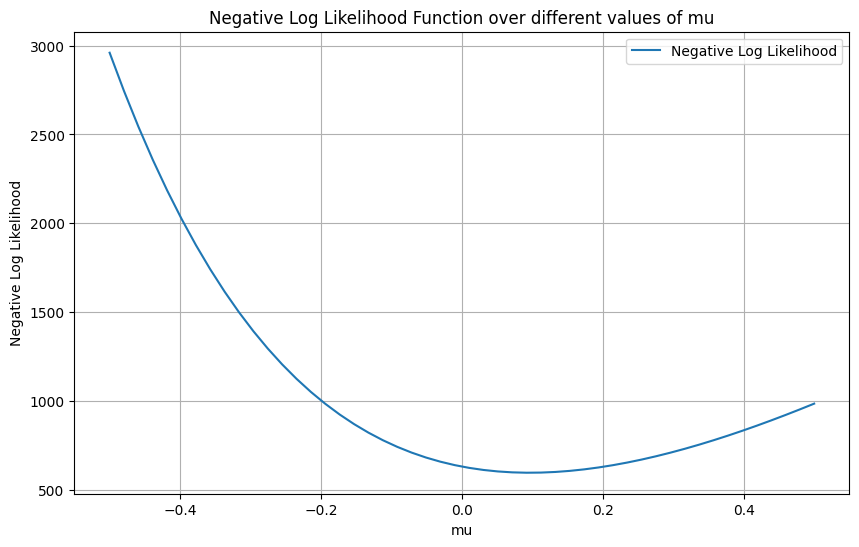

In [ ]:
plot_likelihood(-0.5, 0.5, 50, weibull_likelihood_corrected, "mu", "weibull_belief", alpha, 0, 15)

The mu value that minimizes the negative log likelihood is: -0.010204081632653073
Original value: 0


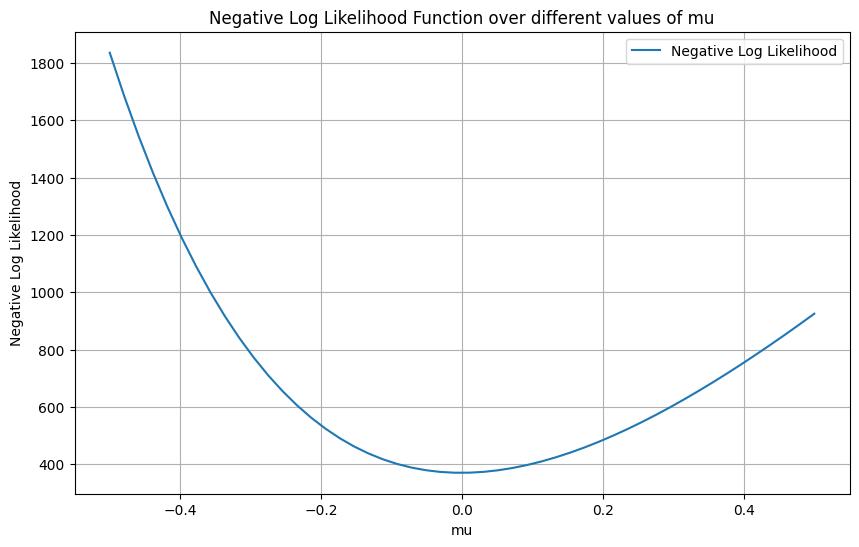

In [ ]:
plot_likelihood(-0.5, 0.5, 50, log_likelihood, "mu", "weibull_lik", alpha, 0, 15)

The alpha value that minimizes the negative log likelihood is: 2.4000000000000004
Original value: 2.9169205004382555


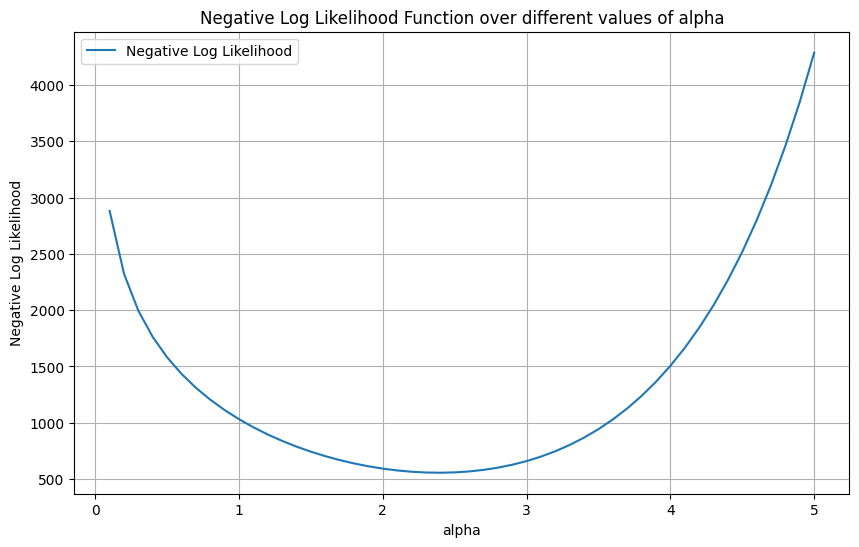

In [ ]:
plot_likelihood(0.1, 5, 50, weibull_likelihood_corrected, "alpha", "weibull_belief", alpha, 0, 15)

The alpha value that minimizes the negative log likelihood is: 3.0000000000000004
Original value: 2.9169205004382555


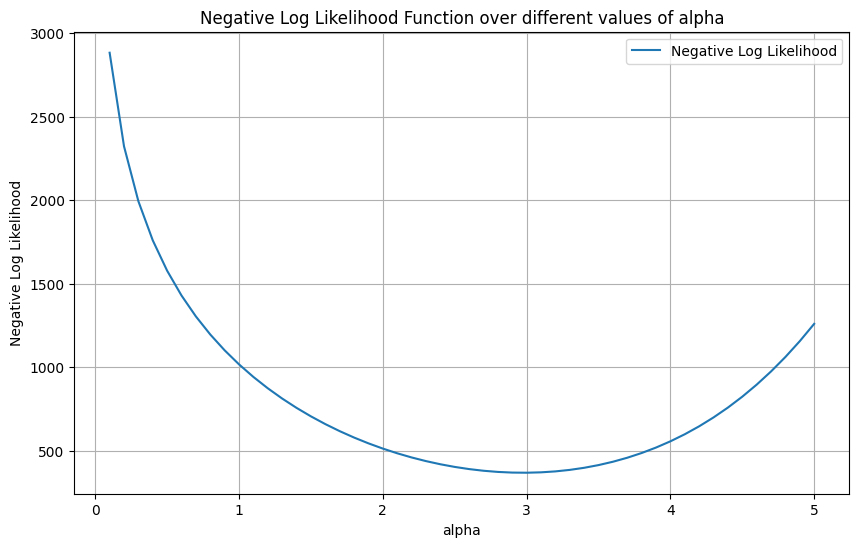

In [ ]:
plot_likelihood(0.1, 5, 50, log_likelihood, "alpha", "weibull_lik", alpha, 0, 15)

In [ ]:
def integrand(z_i, y_i, hat_z_i, xi_k, alpha, mu, K):
    # Calculate the Gaussian probability density function
    gaussian_pdf = norm.pdf(z_i, loc=hat_z_i, scale=np.sqrt(1 / xi_k))
    
    # Calculate the log p(y_i | z_i, alpha, mu)
    log_p = alpha * (np.log(y_i) - mu - z_i) - K - np.exp(alpha * (np.log(y_i) - mu - z_i) - K)
    
    # Return the product of the Gaussian PDF and log p
    return gaussian_pdf * log_p

def compute_integral_sum(y, hat_z, xi_k, alpha, mu, K):
    integral_sum = 0.0
    N = len(y)
    m_error = 0
    
    for i in range(N):
        y_i = y[i]
        hat_z_i = hat_z[i]
        
        # Perform the numerical integration for each term
        integral_value, error = quad(integrand, -100, 100, args=(y_i, hat_z_i, xi_k, alpha, mu, K))
        m_error = max(m_error, error)
        
        # Sum up the integrals
        integral_sum += integral_value
    
    return integral_sum, m_error

In [ ]:
# Example usage with placeholder values
y = np.array([12.0])
hat_z = np.array([34.5])
xi_k = 1.2
alpha = 3.4
mu = 5.6
K = 7.8
result, error = compute_integral_sum(y, X@beta, xi_k, alpha, mu, emc)
print("Result of the integral sum:", result)
print("Maximum error: ", error)
weibull_likelihood(torch.tensor(hat_z), torch.tensor(y), torch.tensor(alpha), torch.tensor(mu), torch.tensor(xi_k), torch.tensor(emc))

Result of the integral sum: -11.556829142182195
Maximum error:  7.901529798959062e-12


tensor(-128.7913, dtype=torch.float64)

In [ ]:
# Generating values for hat_z
hat_z_values = np.linspace(-1, 1, 100)
y = np.array([12.0])
xi_k = 1.2
alpha = 3.4
mu = 5.6
K = 7.8
emc = 0.9

# Computing results for each hat_z
integral_sum_results = [compute_integral_sum(y, np.array([hz]), xi_k, alpha, mu, emc)[0] for hz in hat_z_values]
weibull_likelihood_results = [weibull_likelihood(torch.tensor([hz]), torch.tensor(y), torch.tensor(alpha), torch.tensor(mu), torch.tensor(xi_k), torch.tensor(emc)) for hz in hat_z_values]
weibull_likelihood_results = [w.item() for w in weibull_likelihood_results]

In [ ]:
def integrand(z_i, y_i, hat_z_i, xi_k, alpha, mu, K):
    # Calculate the Gaussian probability density function
    gaussian_pdf = norm.pdf(z_i, loc=hat_z_i, scale=np.sqrt(1 / xi_k))
    
    # Calculate the log p(y_i | z_i, alpha, mu)
    log_p = alpha * (np.log(y_i) - mu - z_i) - K - np.exp(alpha * (np.log(y_i) - mu - z_i) - K) + np.log(alpha)
    
    # Return the product of the Gaussian PDF and log p
    return gaussian_pdf * log_p

def compute_integral_sum(y, hat_z, xi_k, alpha, mu, K):
    integral_sum = 0.0
    N = len(y)
    m_error = 0
    
    for i in range(N):
        y_i = y[i]
        hat_z_i = hat_z[i]
        
        # Perform the numerical integration for each term
        integral_value, error = quad(integrand, -100, 100, args=(y_i, hat_z_i, xi_k, alpha, mu, K))
        m_error = max(m_error, error)
        
        # Sum up the integrals
        integral_sum += integral_value
    
    return integral_sum, m_error

Corrected Weibull likelihood is given by

$$
-\mathrm{e}^{-a{\mu} - az_{hat} - K} \left(Y^{a} \mathrm{e}^{\frac{a^{2}}{2{\xi}}} + \left(a\mathrm{e}^{az_{hat} + K} {\mu} + \left(\mathrm{e}^{K} az_{hat} - \mathrm{e}^{K} \ln\left(a\right) - \mathrm{e}^{K} \ln\left(Y\right) \, a + K\mathrm{e}^{K}\right) \mathrm{e}^{az_{hat}}\right) \mathrm{e}^{a{\mu}}\right)
$$

In [ ]:
# Define the Weibull likelihood function in PyTorch
def weibull_likelihood_corrected(z_hat, Y, a, mu, xi, K):
    term1 = torch.exp(-a * mu - a * z_hat - K)
    term2 = Y ** a * torch.exp(a ** 2 / (2 * xi))
    term3 = a * torch.exp(a * z_hat + K) * mu
    # added a new term: - torch.exp(K) * torch.log(a)
    term4 = (torch.exp(K) * a * z_hat - torch.exp(K) * torch.log(a) - torch.exp(K) * torch.log(Y) * a + K * torch.exp(K)) * torch.exp(a * z_hat)
    term5 = torch.exp(a * mu)

    result = -term1 * (term2 + (term3 + term4) * term5)
    return torch.sum(result)


In [ ]:
# Generating values for hat_z
hat_z_values = np.linspace(-5, 5, 100)
y = np.array([12.0])
xi_k = 1.2
alpha = 3.4
mu = 5.6
K = 7.8
emc = 0.9

# Computing results for each hat_z
integral_sum_results = [compute_integral_sum(y, np.array([hz]), xi_k, alpha, mu, emc)[0] for hz in hat_z_values]
weibull_likelihood_results = [weibull_likelihood_og(torch.tensor([hz]), torch.tensor(y), torch.tensor(alpha), torch.tensor(mu), torch.tensor(xi_k), torch.tensor(emc)) for hz in hat_z_values]
weibull_likelihood_results = [w.item() for w in weibull_likelihood_results]

In [ ]:
d = [integral_sum_results[i] - w for i, w in enumerate(weibull_likelihood_results)]
max(d)

1.2237750662455618

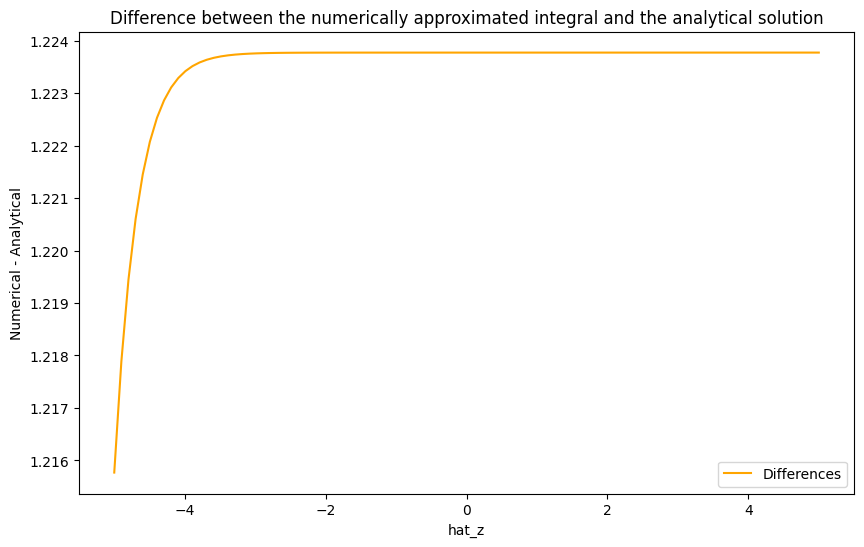

In [ ]:
# Plotting the results on the same figure
plt.figure(figsize=(10, 6))

# Plot for weibull_likelihood
plt.plot(hat_z_values, d, label='Differences', color='orange')

# Adding labels and title
plt.xlabel('hat_z')
plt.ylabel('Numerical - Analytical')
plt.title('Difference between the numerically approximated integral and the analytical solution')
plt.legend()

plt.show()

In [ ]:
# Plotting the results on the same figure
plt.figure(figsize=(10, 6))

# Plot for compute_integral_sum
plt.plot(hat_z_values, integral_sum_results, label='Integral Sum')

# Plot for weibull_likelihood
plt.plot(hat_z_values, weibull_likelihood_results, label='Weibull Likelihood', color='orange')

# Adding labels and title
plt.xlabel('hat_z')
plt.ylabel('Function Result')
plt.title('Integral Sum and Weibull Likelihood vs hat_z')
plt.legend()

plt.show()

In [ ]:
weibull_likelihood(torch.tensor(hat_z), torch.tensor(y), alpha, 0, 1 / torch.var(torch.tensor(X@beta)), emc_t)

In [ ]:
# Assume X, beta, Y, alpha, mu, and emc are already defined
X = torch.tensor(X, dtype=torch.float32)
beta = torch.tensor(beta, dtype=torch.float32)
Y = torch.tensor(y, dtype=torch.float32)
alpha = torch.tensor(2.8, dtype=torch.float32)
mu = torch.tensor(0, dtype=torch.float32, requires_grad=True)
emc_t = torch.tensor(emc, dtype=torch.float32)
# result = weibull_likelihood(torch.tensor(X@beta), Y, alpha, 0.5, 1 / torch.var(torch.tensor(X@beta)), emc)
result = weibull_likelihood(torch.tensor(X@beta), Y, alpha, 0.5, 1 / torch.var(torch.tensor(X@beta)), emc_t)
result.item()

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_15539/637086226.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = weibull_likelihood(torch.tensor(X@beta), Y, alpha, 0.5, 1 / torch.var(torch.tensor(X@beta)), emc_t)


-364805.53125

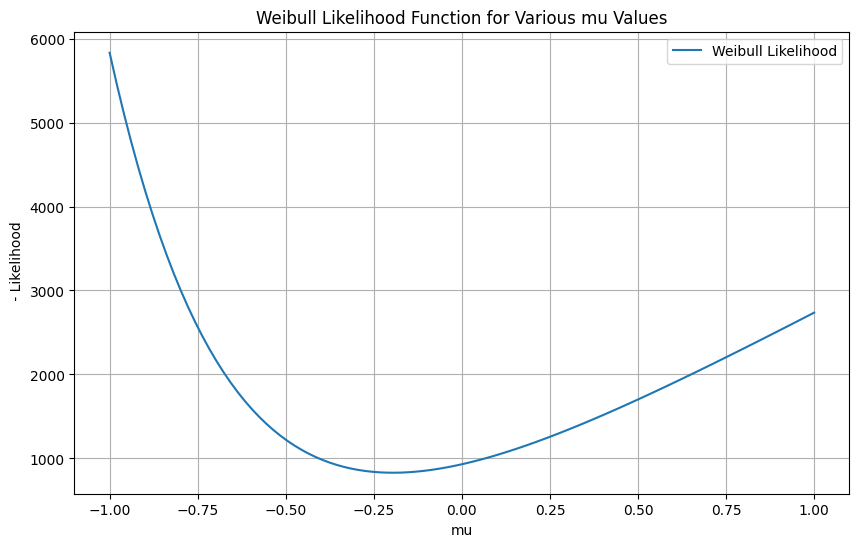

In [ ]:
# Range of mu values
mu_values = np.linspace(-1, 1, 100)

# Calculate the likelihood for each value of mu
likelihood_values = [-weibull_likelihood(X@beta, Y, alpha, torch.tensor(mu, dtype=torch.float32), torch.tensor(1e10), emc_t) for mu in mu_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(mu_values, likelihood_values, label='Weibull Likelihood')
plt.xlabel('mu')
plt.ylabel(' - Likelihood')
plt.title('Weibull Likelihood Function for Various mu Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Convert data to torch tensors
X = torch.tensor(X, dtype=torch.float32)
beta = torch.tensor(beta, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
alpha = torch.tensor(alpha, dtype=torch.float32)
mu = torch.tensor(2.0, dtype=torch.float32, requires_grad=True)

# Calculate z_hat and xi
z_hat = torch.matmul(X, beta)
xi = 1 / torch.var(z_hat)

# Initialize optimizer
optimizer = torch.optim.Adam([mu], lr=0.1)

for j in range(100):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Recalculate the result
    result = -weibull_likelihood(z_hat, Y, alpha, mu, xi, emc_t)
    
    # Backpropagate the error
    result.backward()
    
    # Update the parameters
    optimizer.step()

    # Print the updated mu
    print(mu.item())

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_15539/589130719.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_15539/589130719.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(beta, dtype=torch.float32)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_15539/589130719.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)
/var/folders/3b/v9q3pbyx1r1gb74yk7

1.899999976158142
1.8000065088272095
1.7000268697738647
1.600071668624878
1.500156283378601
1.4003026485443115
1.3005419969558716
1.2009187936782837
1.1014961004257202
1.0023634433746338
0.9036481976509094
0.8055325746536255
0.7082781195640564
0.612262487411499
0.5180336833000183
0.4263887405395508
0.3384811580181122
0.2559491693973541
0.18101823329925537
0.11645559221506119
0.06519334018230438
0.0295657180249691
0.010516690090298653
0.00734670227393508
0.01810375228524208
0.04019412398338318
0.07084520161151886
0.10735742747783661
0.14722654223442078
0.18821071088314056
0.22837521135807037
0.266120970249176
0.3001943826675415
0.32967787981033325
0.35396435856819153
0.3727210760116577
0.38584935665130615
0.39344489574432373
0.39576178789138794
0.3931819200515747
0.3861902356147766
0.37535494565963745
0.3613121509552002
0.3447529077529907
0.3264114558696747
0.3070523738861084
0.2874547243118286
0.2683917284011841
0.2506044805049896
0.2347702980041504
0.2214675396680832
0.211140871047973

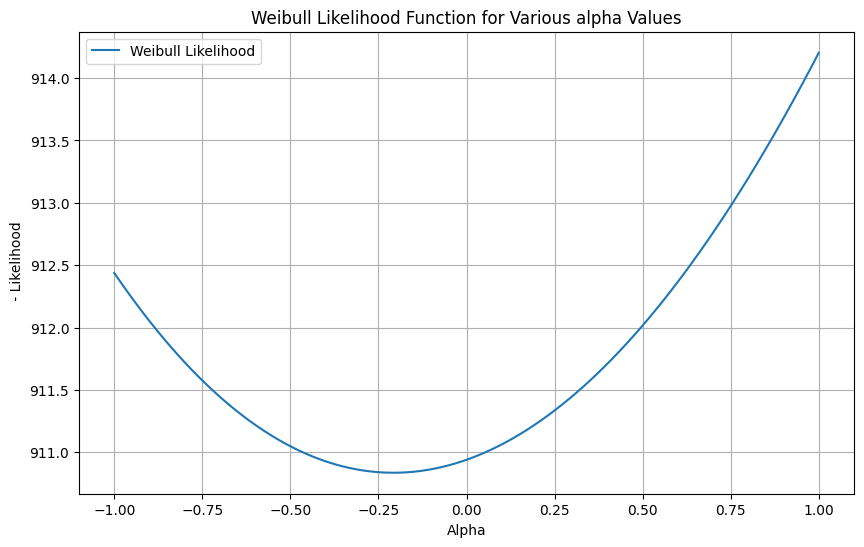

In [ ]:
# Range of mu values
al_values = np.linspace(-1, 1, 100)

# Calculate the likelihood for each value of mu
likelihood_values = [-weibull_likelihood(X@beta, Y, torch.tensor(al, dtype=torch.float32), 0, torch.tensor(1e10), emc_t) for al in al_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(al_values, likelihood_values, label='Weibull Likelihood')
plt.xlabel('Alpha')
plt.ylabel(' - Likelihood')
plt.title('Weibull Likelihood Function for Various alpha Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Convert data to torch tensors
X = torch.tensor(X, dtype=torch.float32)
beta = torch.tensor(beta, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
alpha = torch.tensor(2, dtype=torch.float32, requires_grad=True)
mu = torch.tensor(0, dtype=torch.float32)


# Calculate z_hat and xi
z_hat = torch.matmul(X, beta)
xi = 1 / torch.var(z_hat)

# Initialize optimizer
optimizer = torch.optim.Adam([alpha], lr=0.1)

for j in range(100):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Recalculate the result
    result = -weibull_likelihood(z_hat, Y, alpha, mu, xi, emc_t)
    
    # Backpropagate the error
    result.backward()
    
    # Update the parameters
    optimizer.step()

    # Print the updated mu
    print(alpha.item())

1.899999976158142
1.8004151582717896
1.701508641242981
1.6035300493240356
1.506713628768921
1.4112770557403564
1.317421317100525
1.2253303527832031
1.135171890258789
1.0470980405807495
0.9612465500831604
0.877741813659668
0.7966962456703186
0.7182115912437439
0.6423800587654114
0.5692855715751648
0.499004602432251
0.431607186794281
0.3671574294567108
0.3057140111923218
0.24733035266399384
0.19205458462238312
0.13992932438850403
0.09099109470844269
0.045269716531038284
0.0027873441576957703
-0.03644252568483353
-0.07241621613502502
-0.1051410585641861
-0.1346365362405777
-0.16093537211418152
-0.18408441543579102
-0.20414534211158752
-0.2211950421333313
-0.23532575368881226
-0.2466447949409485
-0.2552739381790161
-0.2613484859466553
-0.26501601934432983
-0.266434907913208
-0.2657725512981415
-0.263203501701355
-0.2589075267314911
-0.25306758284568787
-0.2458677887916565
-0.23749157786369324
-0.22811982035636902
-0.2179291993379593
-0.20709069073200226
-0.19576819241046906
-0.184117406606

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_13060/1200704033.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_13060/1200704033.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(beta, dtype=torch.float32)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_13060/1200704033.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


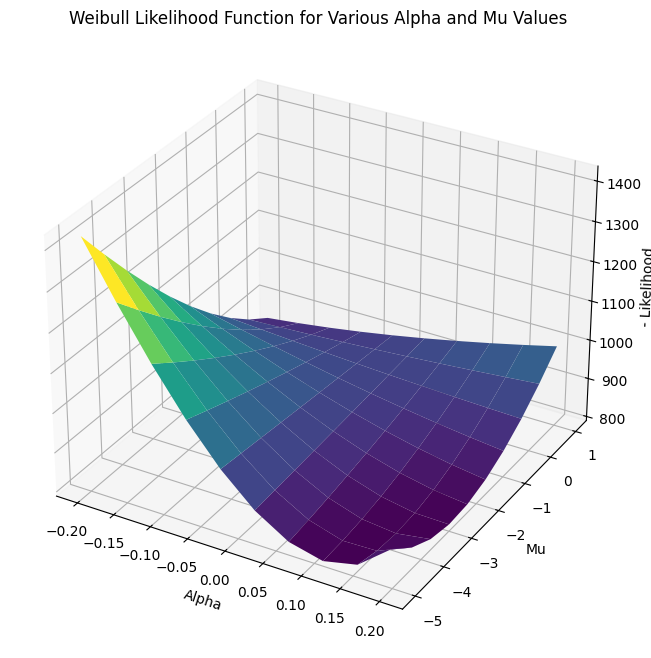

In [ ]:

# Define the range of alpha and mu values
alpha_values = np.linspace(-0.2, 0.2, 10)  # Example range for alpha
mu_values = np.linspace(-5, 1, 10)      # Example range for mu


# Calculate the likelihood for each pair of alpha and mu
likelihood_values = np.zeros((len(alpha_values), len(mu_values)))

for i, alpha in enumerate(alpha_values):
    for j, mu in enumerate(mu_values):
        likelihood_values[i, j] = -weibull_likelihood(X@beta, Y, torch.tensor(alpha, dtype=torch.float32), torch.tensor(mu, dtype=torch.float32), 1/torch.var(X@beta), emc_t)

# Create the meshgrid for alpha and mu
alpha_grid, mu_grid = np.meshgrid(alpha_values, mu_values)

# Plotting the 3D surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_grid, mu_grid, likelihood_values.T, cmap='viridis')

ax.set_xlabel('Alpha')
ax.set_ylabel('Mu')
ax.set_zlabel(' - Likelihood')
ax.set_title('Weibull Likelihood Function for Various Alpha and Mu Values')

plt.show()

In [ ]:
# old_prior = pr
def update_Prior(old_prior, r1, gam1):
    print(old_prior.sigmas.shape)
    print(old_prior.omegas.shape)
    prior = old_prior
    r1 = np.asmatrix(r1)
    omegas = np.transpose(np.asmatrix(old_prior.omegas))
    sigmas = np.transpose(np.asmatrix(old_prior.sigmas))
    sigmas_max = np.max(old_prior.sigmas)
    gam1inv = 1.0/gam1
    # np.exp( - np.power(np.transpose(r1),2) / 2 @ (sigmas_max - sigmas) / (sigmas_max + gam1inv) / (sigmas + gam1inv)) has shape = (P,L) and  omegas / np.sqrt(gam1inv + sigmas) has shape = (1, L)
    t1 = np.exp( - np.power(np.transpose(r1),2) / 2 @ (sigmas_max - sigmas) / (sigmas_max + gam1inv) / (sigmas + gam1inv))
    t2 = omegas / np.sqrt(gam1inv + sigmas)
    beta_tilde=np.multiply( t1, t2 )
    sum_beta_tilde = beta_tilde.sum(axis=1)
    beta_tilde=beta_tilde / sum_beta_tilde
    # pi.shape = (P, 1)
    pi = 1.0 / ( 1.0 + (1-prior.la * np.exp(-np.power(np.transpose(r1),2) / 2 * sigmas_max * gam1 / (sigmas_max + gam1inv) ) / np.sqrt(gam1inv) ) / sum_beta_tilde )
    gamma = np.divide(np.transpose(r1) * gam1, gam1 + 1.0/sigmas )
    # v.shape = (1,L)
    v = 1.0 / (gam1 + 1.0/sigmas)

    #updating sparsity level
    prior.la = np.mean(pi)
    #updating variances in the mixture
    prior.sigmas = (np.transpose(pi) @ np.multiply( beta_tilde , (np.power(gamma,2) + v)) ) / (np.transpose(pi) @ beta_tilde)
    #updating prior probabilities in the mixture
    prior.omegas = (np.transpose(pi) @ beta_tilde ) / np.sum(pi)
    return prior

In [ ]:
def den_beta_mixture(r, gam1, prior):
    """
    Actually computes a mixture of Gaussians instead of just one Gaussian 
    """
    # By treating the coefficients beta_i as independent, we work with 1d Gaussians only.
    
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    A_der = A * (-r * gam1)

    B_tot = 0
    ratio_der = 0
    B_tot_der = 0
    for e, pi in zip(prior.sigmas, prior.omegas):
        B = pi * prior.la * norm.pdf(r, loc=0, scale=np.sqrt(e + 1.0/gam1))
        B_tot += B
        # Derivative of term1
        # Compute the derivative of B as the sum of derivatives of the individual terms
        B_der = B * (-r / (e + 1.0/gam1))
        num_term1 = B * e / (e + 1/gam1)
        num_term2 = B_der * e * r / (e + 1/gam1)
        B_tot_der += num_term1 + num_term2


    # Derivative of ratio
    ratio = B / (A + B)
    ratio_der = (B_tot_der * A - A_der * B_tot) / (A+B) / (A+B)
    
    return ratio, ratio_der

In [ ]:
def den_beta_mixture(r, gam1, prior):
    """
    Actually computes a mixture of Gaussians instead of just one Gaussian 
    """
    # By treating the coefficients beta_i as independent, we work with 1d Gaussians only.
    
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    A_der = A * (-r * gam1)

    B_tot = 0
    ratio_der = 0
    B_tot_der = 0
    for e, pi in zip(prior.sigmas, prior.omegas):
        B = pi * prior.la * norm.pdf(r, loc=0, scale=np.sqrt(e + 1.0/gam1))
        B_tot += B
        # Derivative of term1
        # Compute the derivative of B as the sum of derivatives of the individual terms
        B_der = B * (-r / (e + 1.0/gam1))
        num_term1 = B * e / (e + 1/gam1)
        num_term2 = B_der * e * r / (e + 1/gam1)
        B_tot_der += num_term1 + num_term2


    # Derivative of ratio
    ratio = B / (A + B)
    ratio_der = (B_tot_der * A - A_der * B_tot) / ((A+B)**2)
    
    return ratio, ratio_der

In [ ]:
def der_den_beta(r,gam1,prior): # checked!
    # Derivative of the Gaussians with respect to r
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    print(A.shape)
    print(r.shape)
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (prior.sigmas[0] + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/prior.sigmas[0]))
    print("alpha1 part I = ", gam1 / (gam1 + 1/prior.sigmas[0]) * B[1] / (A[1] + B[1]))
    print("alpha2 part II = ", BoverAplusBder[1] * r[1] * gam1 / (gam1 + 1.0/prior.sigmas[0]) )
    ratio = gam1 / (gam1 + 1/prior.sigmas[0]) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/prior.sigmas[0])
    return ratio